In [1]:
#Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import os
import zipfile
import os
import re


In [2]:
# CSV file load
csv_url = "https://raw.githubusercontent.com/romane-lg/Ontario-Court-Cases/main/data/canlii_final_report_20.csv"
df = pd.read_csv(csv_url)
print(f"CSV loaded: {len(df)} rows")


# Reading txt files from GitHub
api_url = "https://api.github.com/repos/romane-lg/Ontario-Court-Cases/contents/data/data_clean"
response = requests.get(api_url)
response.raise_for_status()

files = response.json()
txt_files = [f for f in files if f["name"].endswith(".txt")]
print(f"Found {len(txt_files)} txt files on GitHub")


# URL → txt mapping
url_to_text = {}

for file_info in txt_files:
    raw_url = file_info["download_url"]
    text = requests.get(raw_url).text

    for line in text.splitlines():
        if line.lower().startswith("source url:"):
            url = line.split(":", 1)[1].strip()
            url_to_text[url] = text
            break

# Alignment with csv
texts = []
missing_urls = []

for url in df["URL"]:
    if url in url_to_text:
        texts.append(url_to_text[url])
    else:
        texts.append("")
        missing_urls.append(url)

df["full_text"] = texts

print(f"Matched texts : {len(df) - len(missing_urls)}")
print(f"Missing texts : {len(missing_urls)}")

CSV loaded: 510 rows
Found 509 txt files on GitHub
Matched texts : 509
Missing texts : 1


### Sentence-BERT embeddings - Topic Modeling

In [3]:
!pip install sentence-transformers

In [4]:
!pip install hdbscan

In [5]:
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [6]:
#Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight, fast for 500+ cases
embeddings = model.encode(texts, show_progress_bar=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

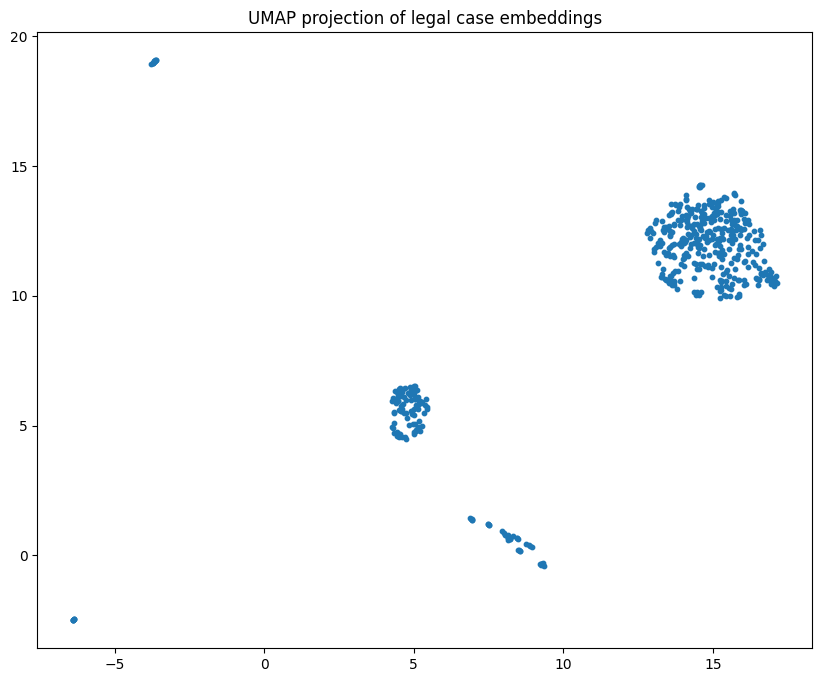

In [7]:
#Dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], s=10)
plt.title("UMAP projection of legal case embeddings")
plt.show()



The BERT sentence embedding approach seperated the cases into 3-4 groups. There is one larger cluster on the right, a medium one, a smaller one and one that seems to relate to outliers. However, since our sample is small to represent all possible criminal offense, we will chose to go with 4 clusters to represent the different cases complexities.

In [8]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(embeddings)

df['Cluster'] = cluster_labels

print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
print(df[['Case_Title', 'Cluster']].head(10))

Number of clusters found: 6
       Case_Title  Cluster
0      R. v. M.T.        4
1      R. v. J.G.        1
2  R. v. Laguerre        4
3     R. v. Khosa        1
4  R. v. Lachance        1
5     R. v. Eagen        1
6   R. v. Burnett        5
7    R. v. Nguyen       -1
8      R. v. P.G.        4
9    R. v. Cheema        1


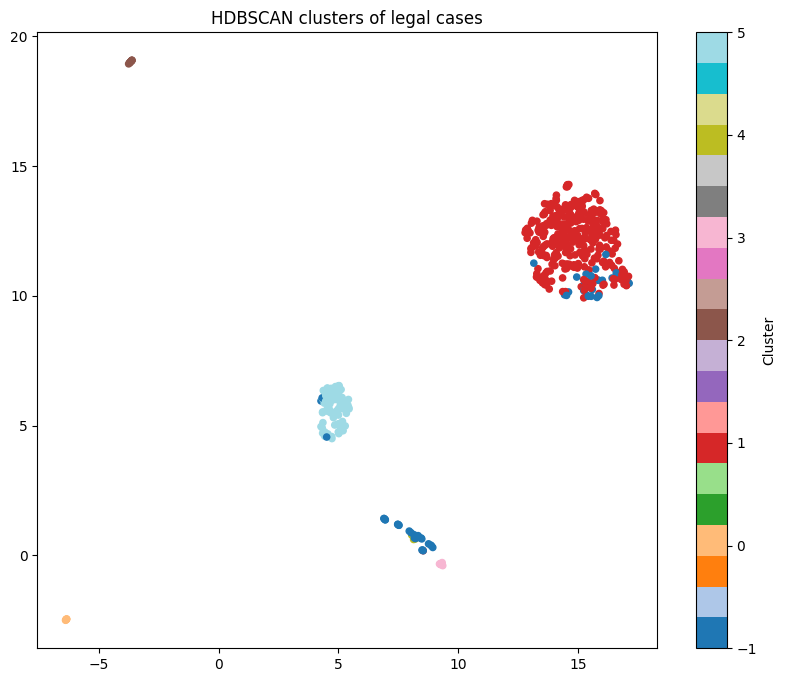

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=cluster_labels, cmap='tab20', s=20)
plt.colorbar(label='Cluster')
plt.title("HDBSCAN clusters of legal cases")
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

#Extact the top key words per cluster
def get_top_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Sum TF-IDF scores per term across all documents
    tfidf_sums = X.sum(axis=0).A1
    top_indices = tfidf_sums.argsort()[::-1][:top_n]

    return feature_names[top_indices]

# Group texts by cluster
clusters = df['Cluster'].unique()
for cluster in clusters:
    if cluster == -1:
        continue  # -1 is noise in HDBSCAN
    cluster_texts = [text for text, lbl in zip(texts, cluster_labels) if lbl == cluster]
    top_words = get_top_keywords(cluster_texts, top_n=10)
    print(f"Cluster {cluster}: {', '.join(top_words)}")

Cluster 4: complainant, mother, defendant, testified, sex, hair, messages, activity, phone, home
Cluster 1: sentence, offender, ms, defendant, officer, delay, sentencing, applicant, years, firearm
Cluster 5: mr, sentence, offender, complainant, defendant, accused, ms, testified, sentencing, applicant
Cluster 2: sentence, db, ycja, custody, delay, accused, complainant, para, search, probation
Cluster 0: 25, number, file, 998, 23, 04, 00, 03
Cluster 3: ms, sentence, offender, testified, mother, delay, asked, victims, video, party


**Cluster Analysis**:
- Cluster 4 (Sexual Offensses possibly involving minors):
    * This cluster seems to involve sexual offenses, likely sexual assault cases, potentially involving minors (with words like mother, complainant) or family / household context
    * Evidence often comes from testimony, messages, or phone activity

- Cluster 1 (Violent crimes / firearm offenses):
    * Keywords like forearm and officer suggest weapon-related iffenses or violent crimes
    * sentence, years, delay -> procedural / sentencimg context, probably serious criminal offenses

- Cluster 5 (General criminal offenses / mixed cases):
    * Generic crimial law terms (offender, accused, testified)
    * Seems like general sentencing cases, maybe property crimes or minor assaults

- Cluster 2 (Youth criminal offenses):
    * YCJA refers to Youth Criminal Justice Act, so this cluster refers to youth criminal cases
    * custody, probabtion, search seems to also refer to sentencing and procedural aspects of youth criminal cases

- Cluster 0 (groupping of file):
    * seems to be a groupping of boilerplate / numeric references
    * needs to be investigated manually

- Cluster 3 (sexual / assault offenses):
    * Mentions of victims, mother, video, party → sexual or assault-related cases, possibly domestic or youth sexual offenses.
    * Overlaps somewhat with Cluster 4, but maybe more procedural focus or different type of sexual/assault cases.


In [11]:
# List cases in Cluster 0
cluster_0_cases = df[df['Cluster'] == 0]

print(f"Total cases in Cluster 0: {len(cluster_0_cases)}\n")

# Show relevant info: Case Title + URL
for idx, row in cluster_0_cases.iterrows():
    print(f"Row {idx}: {row['Case_Title']} -> {row['URL']}")


Total cases in Cluster 0: 7

Row 33: R. v. Desouza -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj645/2025oncj645.html
Row 103: R. v. A.E. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj550/2025oncj550.html
Row 279: R. v. C.N. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj308/2025oncj308.html
Row 337: R. v. B.H. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj222/2025oncj222.html
Row 379: R. v. Smith -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj165/2025oncj165.html
Row 388: R. v. M.R. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj155/2025oncj155.html
Row 483: R. v. T.J. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj23/2025oncj23.html


The cases in cluster 0 refer to cases that have not been resolved yet, thus follows the same case content. It make sense they have been groupped together

In [12]:
# Count number of cases per cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

print("Number of cases per cluster:\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} cases")


Number of cases per cluster:

Cluster -1: 52 cases
Cluster 0: 7 cases
Cluster 1: 336 cases
Cluster 2: 12 cases
Cluster 3: 9 cases
Cluster 4: 8 cases
Cluster 5: 86 cases


Cluster 1 is the most populated, containing 336 cases. Other clusters, such as 3 and 4, have fewer cases, which aligns with our interpretation that Clusters 3 and 4 are related to sexual offenses — with Cluster 4 likely focusing more on youth cases and Cluster 3 on general assaults.

Now, we aim to sub-cluster cluster -1, 1 and 5 to identify more precise offense groups within each.

Regarding Cluster -1, these are the noise points identified by HDBSCAN. They represent cases that the algorithm could not confidently assign to any cluster, often because they are outliers or have ambiguous content.

### Topic Modeling 2nd iteration

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Processing Cluster -1 (52 cases)


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

  Subcluster 0: 23 cases | Top words: defendant, sentence, ms, officer, offender, charter, breath, vehicle, para, allen
  Subcluster 1: 5 cases | Top words: defendant, complainant, sentence, ms, mr, accused, para, incident, offender, sentencing
  Subcluster 2: 4 cases | Top words: ms, complainant, force, website, fear, threatening, children, time, stated, mr
  Subcluster 3: 12 cases | Top words: mr, sentence, ms, defendant, offender, messages, delay, records, consent, doubt


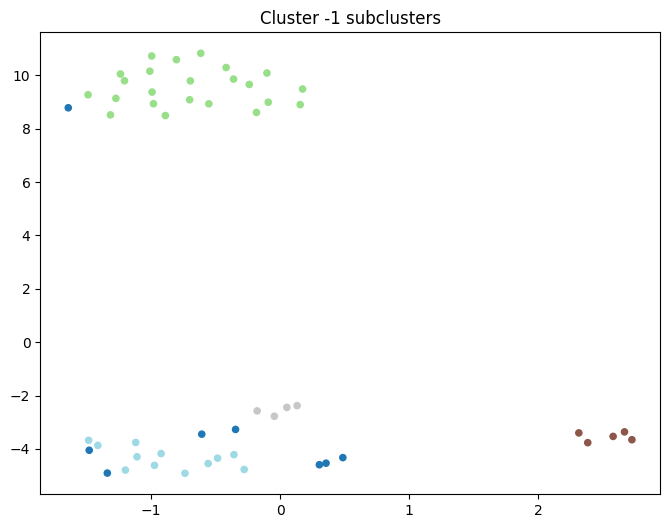


Processing Cluster 1 (336 cases)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

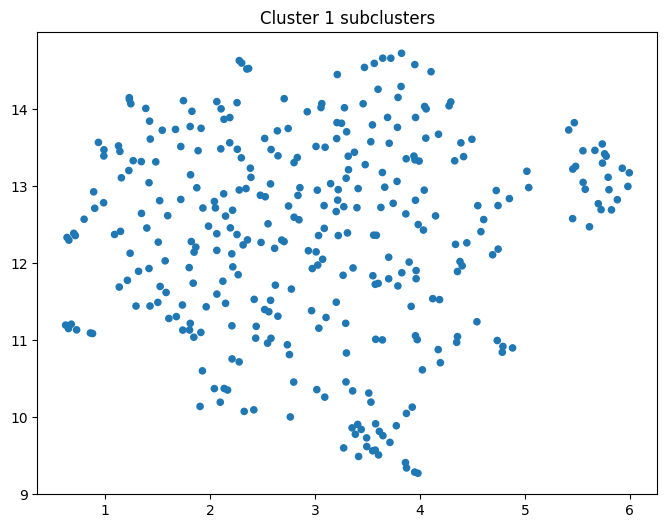


Processing Cluster 5 (86 cases)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

  Subcluster 0: 4 cases | Top words: applicant, mr, evidence, defendant, said, vagina, submissions, orders, touching, old
  Subcluster 1: 5 cases | Top words: mr, offender, complainant, applicant, sentence, child, testify, para, august, children


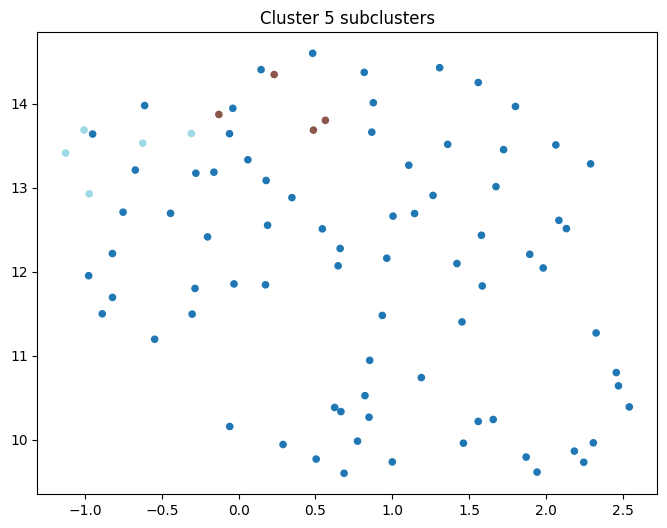


Sub-clustering complete! Selected clusters now have subcluster labels and top keywords.


In [13]:
# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight & fast

# Only sub-cluster these main clusters
clusters_to_process = [-1, 1, 5]

# Dictionary to store subcluster labels and top words
subcluster_results = {}
subcluster_keywords = {}

# Function to get top TF-IDF words for a list of texts
def get_top_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())
    tfidf_sums = X.sum(axis=0).A1
    top_indices = tfidf_sums.argsort()[::-1][:top_n]
    return feature_names[top_indices]

# Loop through selected clusters and sub-cluster
for cluster in clusters_to_process:
    cluster_mask = df['Cluster'] == cluster
    cluster_texts = [text for text, mask in zip(texts, cluster_mask) if mask]

    if len(cluster_texts) == 0:
        continue

    print(f"\nProcessing Cluster {cluster} ({len(cluster_texts)} cases)")

    # Generate embeddings
    embeddings = model.encode(cluster_texts, show_progress_bar=True)

    # HDBSCAN sub-clustering
    subclusterer = hdbscan.HDBSCAN(
        min_cluster_size=3,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    subcluster_labels = subclusterer.fit_predict(embeddings)

    # Store subcluster labels
    subcluster_results[cluster] = subcluster_labels

    # Store top keywords per subcluster
    subcluster_keywords[cluster] = {}
    unique_subclusters = np.unique(subcluster_labels)

    for sc in unique_subclusters:
        if sc == -1:
            continue  # skip noise
        sc_texts = [text for text, lbl in zip(cluster_texts, subcluster_labels) if lbl == sc]
        top_words = get_top_keywords(sc_texts, top_n=10)
        subcluster_keywords[cluster][sc] = top_words
        print(f"  Subcluster {sc}: {len(sc_texts)} cases | Top words: {', '.join(top_words)}")

    # Optional: UMAP visualization
    umap_embeddings = umap.UMAP(
        n_neighbors=15,
        n_components=2,
        metric='cosine'
    ).fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    plt.scatter(
        umap_embeddings[:,0],
        umap_embeddings[:,1],
        c=subcluster_labels,
        cmap='tab20',
        s=20
    )
    plt.title(f"Cluster {cluster} subclusters")
    plt.show()

# Add subcluster labels to df
for cluster, labels in subcluster_results.items():
    mask = df['Cluster'] == cluster
    df.loc[mask, f'Subcluster_{cluster}'] = labels

print("\nSub-clustering complete! Selected clusters now have subcluster labels and top keywords.")



In [14]:
#print the top keywords per sub-cluster

print("Top keywords per subcluster:\n")

for cluster in subcluster_keywords:
    print(f"Main Cluster {cluster}:")
    for sc, words in subcluster_keywords[cluster].items():
        print(f"  Subcluster {sc} ({len([text for text, lbl in zip(texts, df['Cluster']) if lbl == cluster])} cases): {', '.join(words)}")
    print()


Top keywords per subcluster:

Main Cluster -1:
  Subcluster 0 (52 cases): defendant, sentence, ms, officer, offender, charter, breath, vehicle, para, allen
  Subcluster 1 (52 cases): defendant, complainant, sentence, ms, mr, accused, para, incident, offender, sentencing
  Subcluster 2 (52 cases): ms, complainant, force, website, fear, threatening, children, time, stated, mr
  Subcluster 3 (52 cases): mr, sentence, ms, defendant, offender, messages, delay, records, consent, doubt

Main Cluster 1:

Main Cluster 5:
  Subcluster 0 (86 cases): applicant, mr, evidence, defendant, said, vagina, submissions, orders, touching, old
  Subcluster 1 (86 cases): mr, offender, complainant, applicant, sentence, child, testify, para, august, children



**Sub-Cluster Analysis**

- Cluster -1:
    * Subcluster 0: Likely procedural or traffic/Charter-related cases, including vehicle offenses, driving under influence, or other legal procedural matters.
     * Subcluster 1: Probably general criminal cases, possibly minor assaults, property crimes, or mixed offenses; broadly procedural with no strong thematic signal.
     * Subcluster 2: Likely sexual offenses or threats, some involving minors, possibly online/technology-facilitated offenses.
     * Subcluster 3: ikely assault or sexual consent-related cases, procedural context emphasized (delay, records, consent), overlaps with sexual/offense context.

- Cluster 5:
    * Subcluster 0: Likely child-related general criminal cases, maybe minor abuse or family-related criminal offenses. Procedural and sentencing context is strong.
     * Subcluster 1:Likely sexual offenses in social contexts, possibly assaults at parties or social gatherings, involving victims and witnesses.


In [18]:
df

,Judge,Heard_Date,Released_Date,Case_Title,URL,full_text,Cluster,Subcluster_-1,Subcluster_1,Subcluster_5,Released_Date_dt,Heard_Date_dt,case_duration_days
0,C.A. Brannagan,27 November 2025,2025-12-31,R. v. M.T.,https://www.canlii.org/en/on/oncj/doc/2025/202...,source url: https://www.canlii.org/en/on/oncj/...,4,NaN,NaN,NaN,2025-12-31,2025-11-27,34.0
1,Fergus ODonnell,Unknown,2025-12-30,R. v. J.G.,https://www.canlii.org/en/on/oncj/doc/2025/202...,source url: https://www.canlii.org/en/on/oncj/...,1,NaN,-1.0,NaN,2025-12-30,NaT,NaN
2,S. Robichaud,"October 27 to October 31, November 12, 17-25, ...",2025-12-29,R. v. Laguerre,https://www.canlii.org/en/on/oncj/doc/2025/202...,source url: https://www.canlii.org/en/on/oncj/...,4,NaN,NaN,NaN,2025-12-29,NaT,NaN
3,S. Robichaud,"December 29, 2025",2025-12-29,R. v. Khosa,https://www.canlii.org/en/on/oncj/doc/2025/202...,source url: https://www.canlii.org/en/on/oncj/...,1,NaN,-1.0,NaN,2025-12-29,NaT,NaN
4,S. G. Pratt,"4 November, 17 December, 2025",2025-12-24,R. v. Lachance,https://www.canlii.org/en/on/oncj/doc/2025/202...,source url: https://www.canlii.org/en/on/oncj/...,1,NaN,-1.0,NaN,2025-12-24,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,Brock Jones,"June 13, 2023, and December 10, 2024",2025-01-06,R. v. Aden,https://www.canlii.org/en/on/oncj/doc/2025/202...,,-1,-1.0,NaN,NaN,2025-01-06,NaT,NaN
506,Brock Jones,"October 15-17, 28, and December 19, 2024",2025-01-06,R. v. A.B.,https://www.canlii.org/en/on/oncj/doc/2025/202...,source url: https://www.canlii.org/en/on/oncj/...,2,NaN,NaN,NaN,2025-01-06,NaT,NaN
507,H. Pringle,"December 6, 2024 [1]",2025-01-03,R. v. Williams,https://www.canlii.org/en/on/oncj/doc/2025/202...,source url: https://www.canlii.org/en/on/oncj/...,1,NaN,-1.0,NaN,2025-01-03,NaT,NaN
508,Unknown,Unknown,2025-01-02,R. v. Wu,https://www.canlii.org/en/on/oncj/doc/2025/202...,source url: https://www.canlii.org/en/on/oncj/...,1,NaN,-1.0,NaN,2025-01-02,NaT,NaN



=== Cluster -1 Statistics ===
Number of Judges: 18
Average Case Duration: 52.48 days


/tmp/ipython-input-1034607151.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



=== Cluster 0 Statistics ===
Number of Judges: 1
Average Case Duration: nan days


/tmp/ipython-input-1034607151.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



=== Cluster 1 Statistics ===
Number of Judges: 105
Average Case Duration: 46.44 days


/tmp/ipython-input-1034607151.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



=== Cluster 2 Statistics ===
Number of Judges: 9
Average Case Duration: 24.90 days


/tmp/ipython-input-1034607151.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



=== Cluster 3 Statistics ===
Number of Judges: 8
Average Case Duration: 59.25 days


/tmp/ipython-input-1034607151.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



=== Cluster 4 Statistics ===
Number of Judges: 7
Average Case Duration: 46.83 days


/tmp/ipython-input-1034607151.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



=== Cluster 5 Statistics ===
Number of Judges: 40
Average Case Duration: 85.23 days


/tmp/ipython-input-1034607151.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


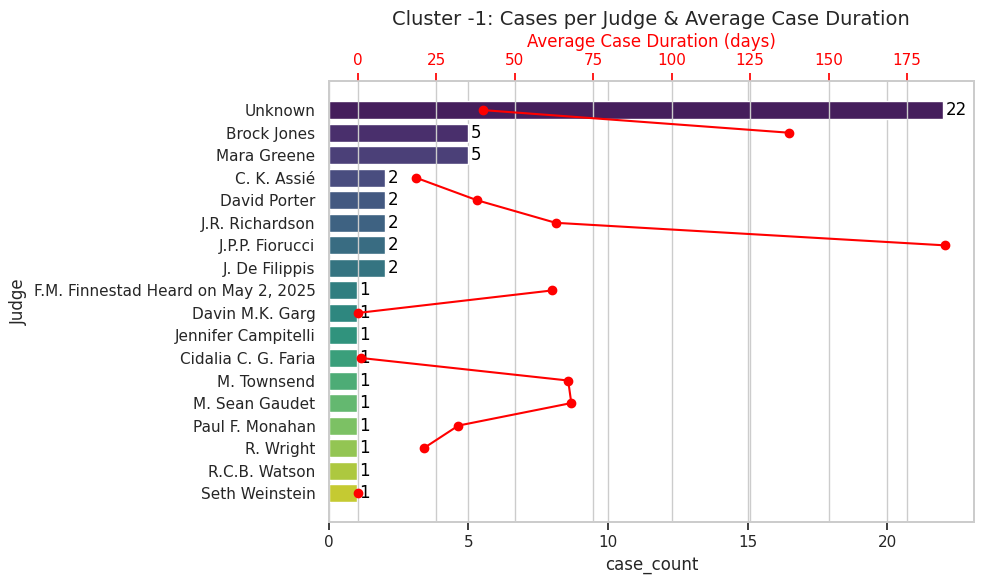

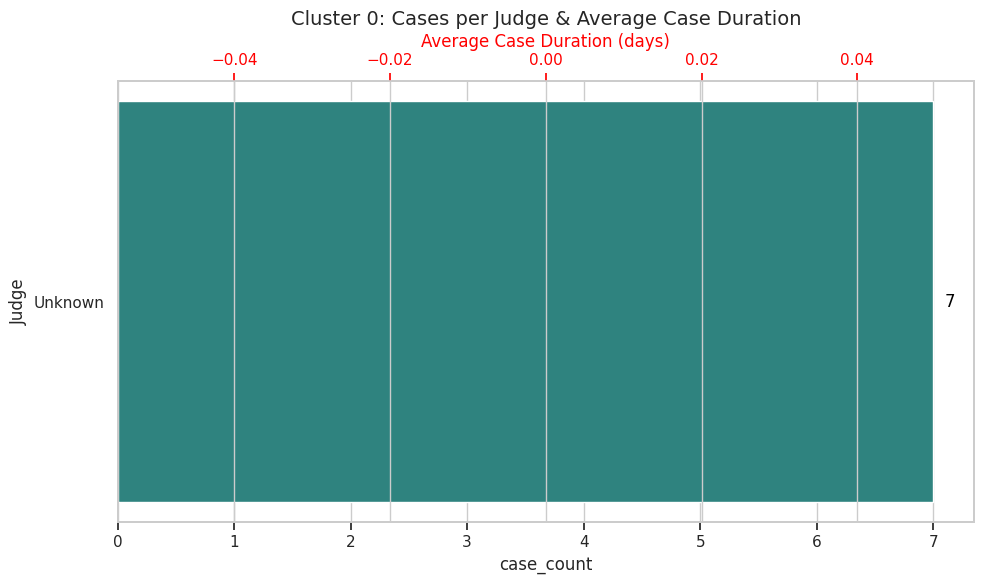

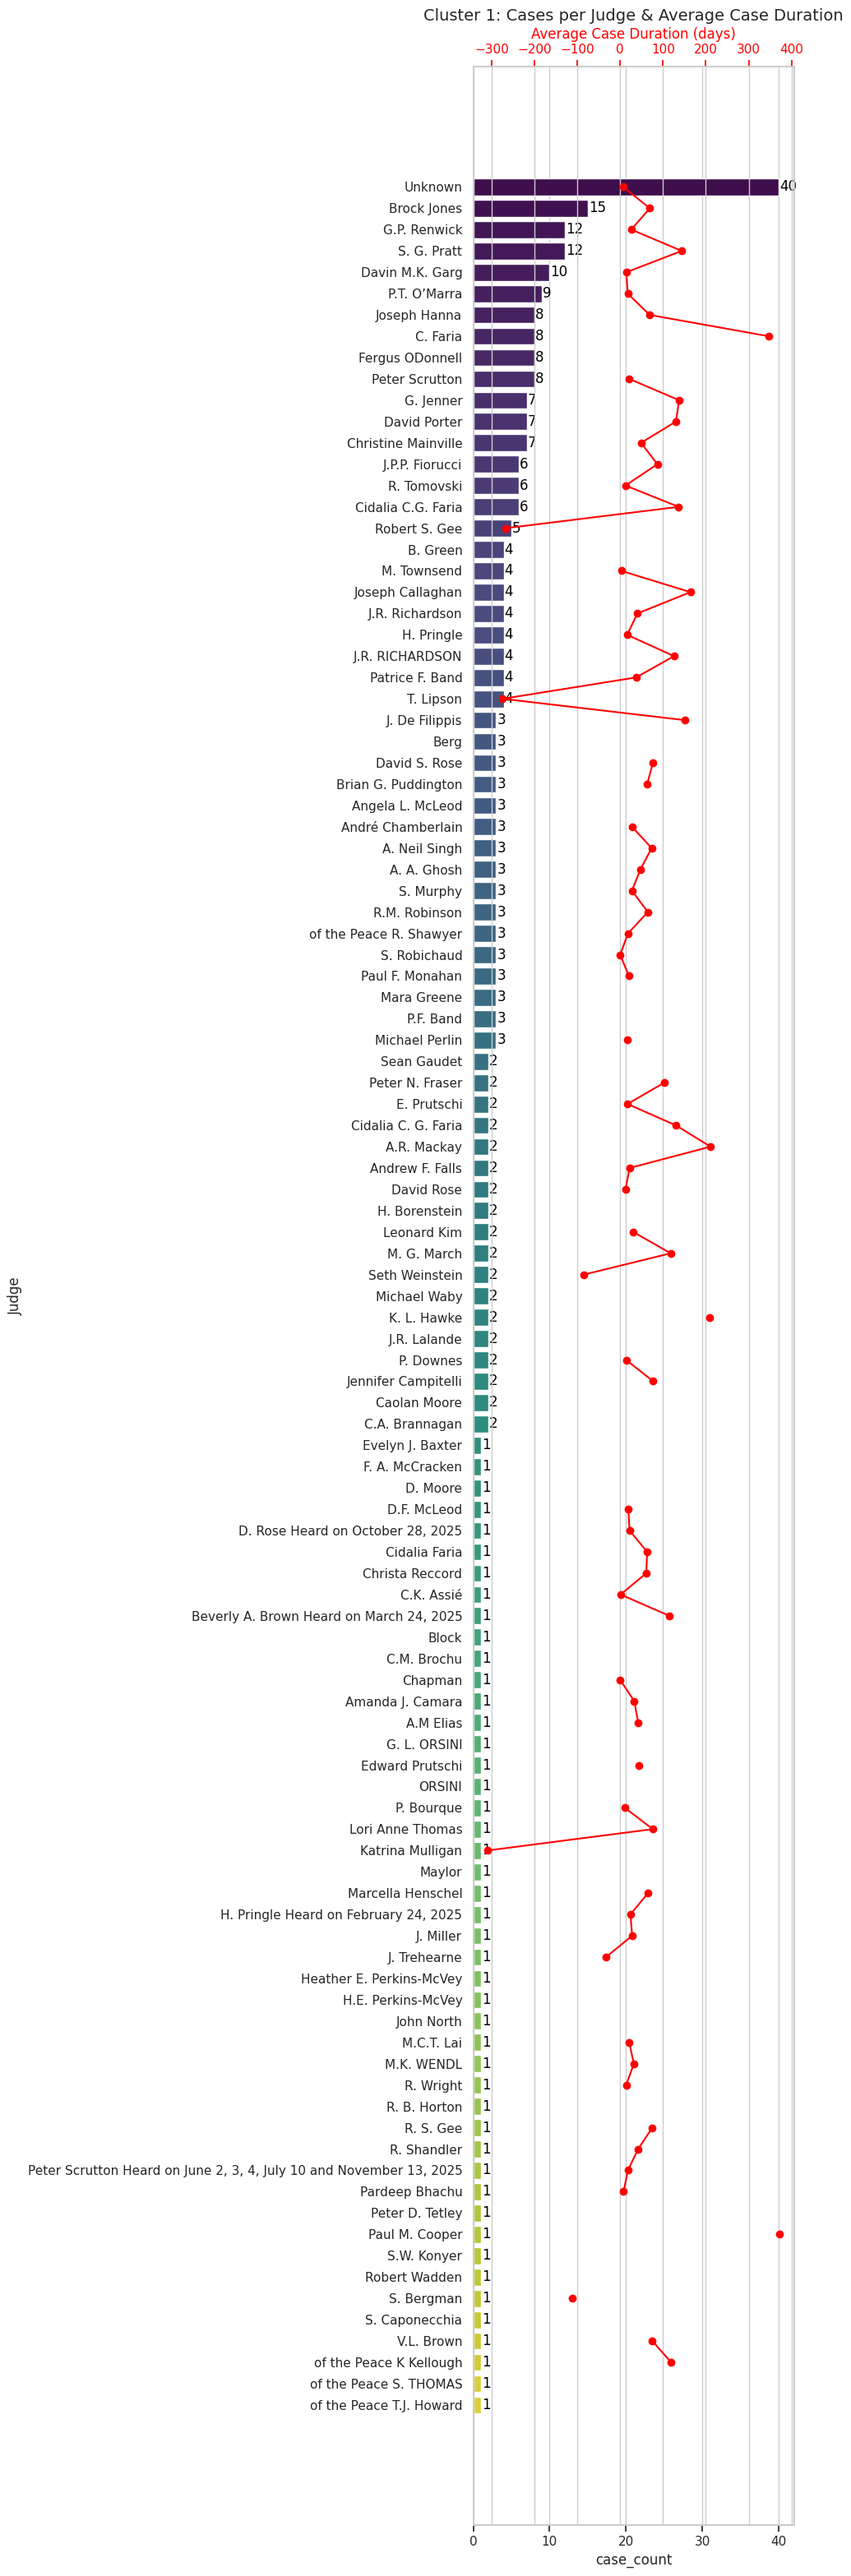

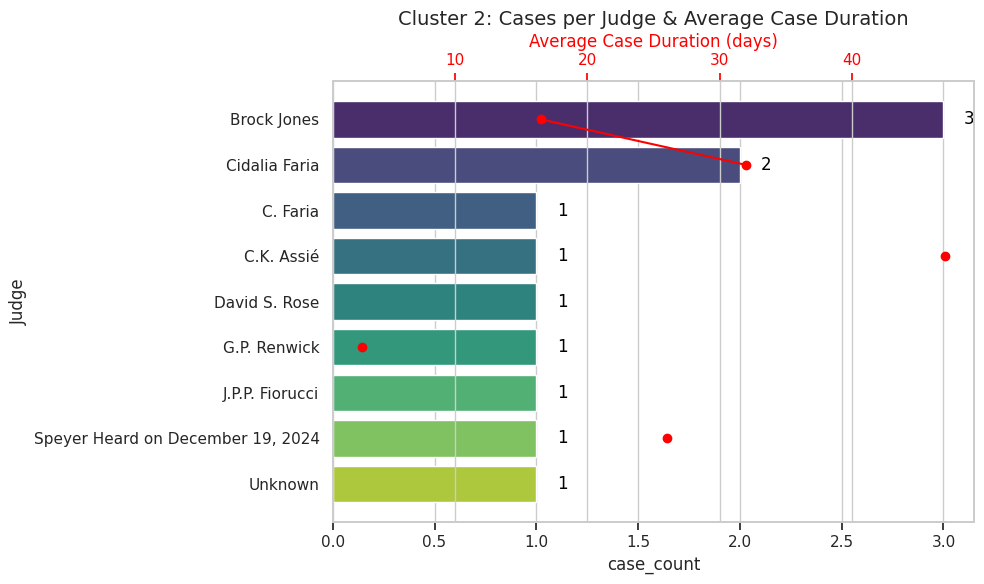

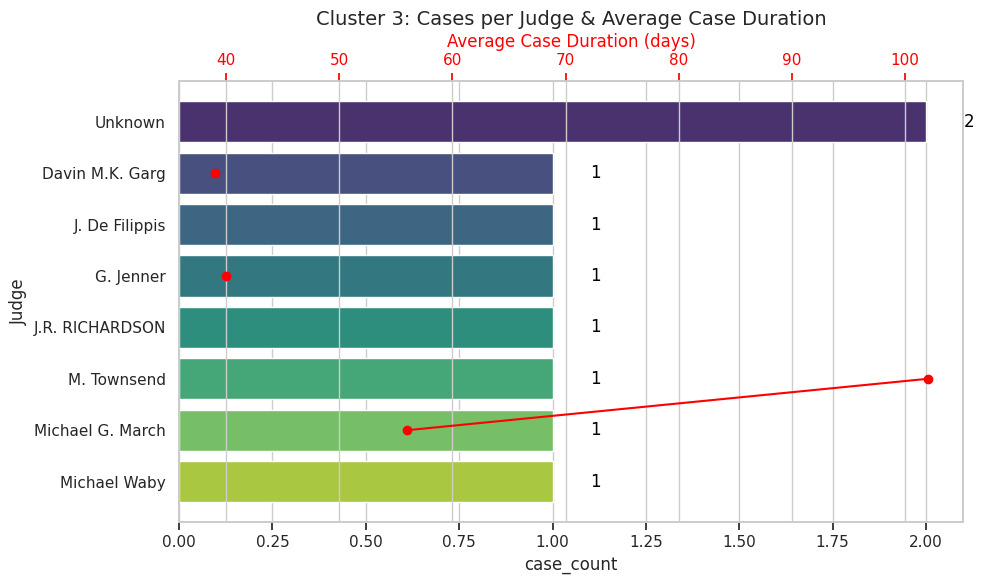

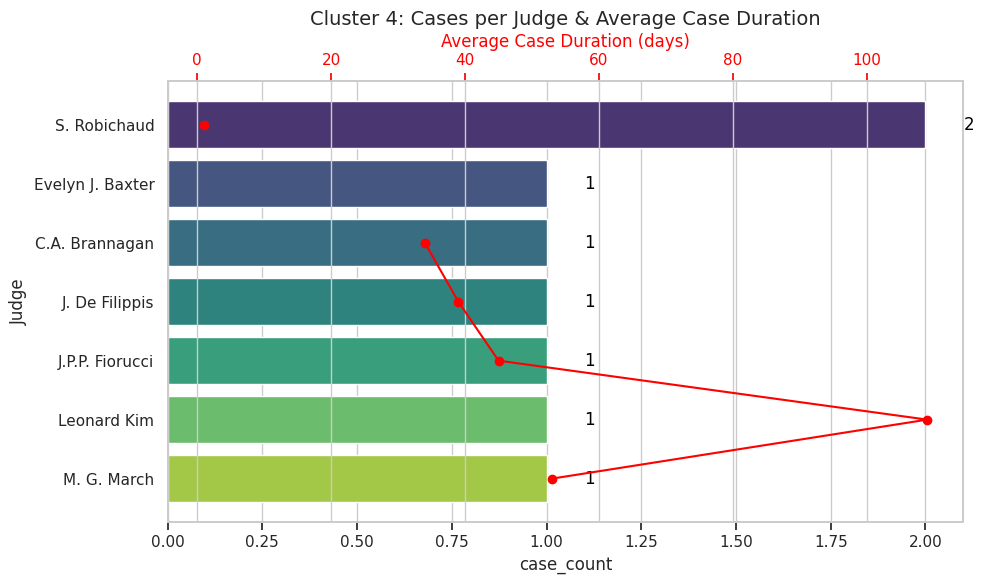

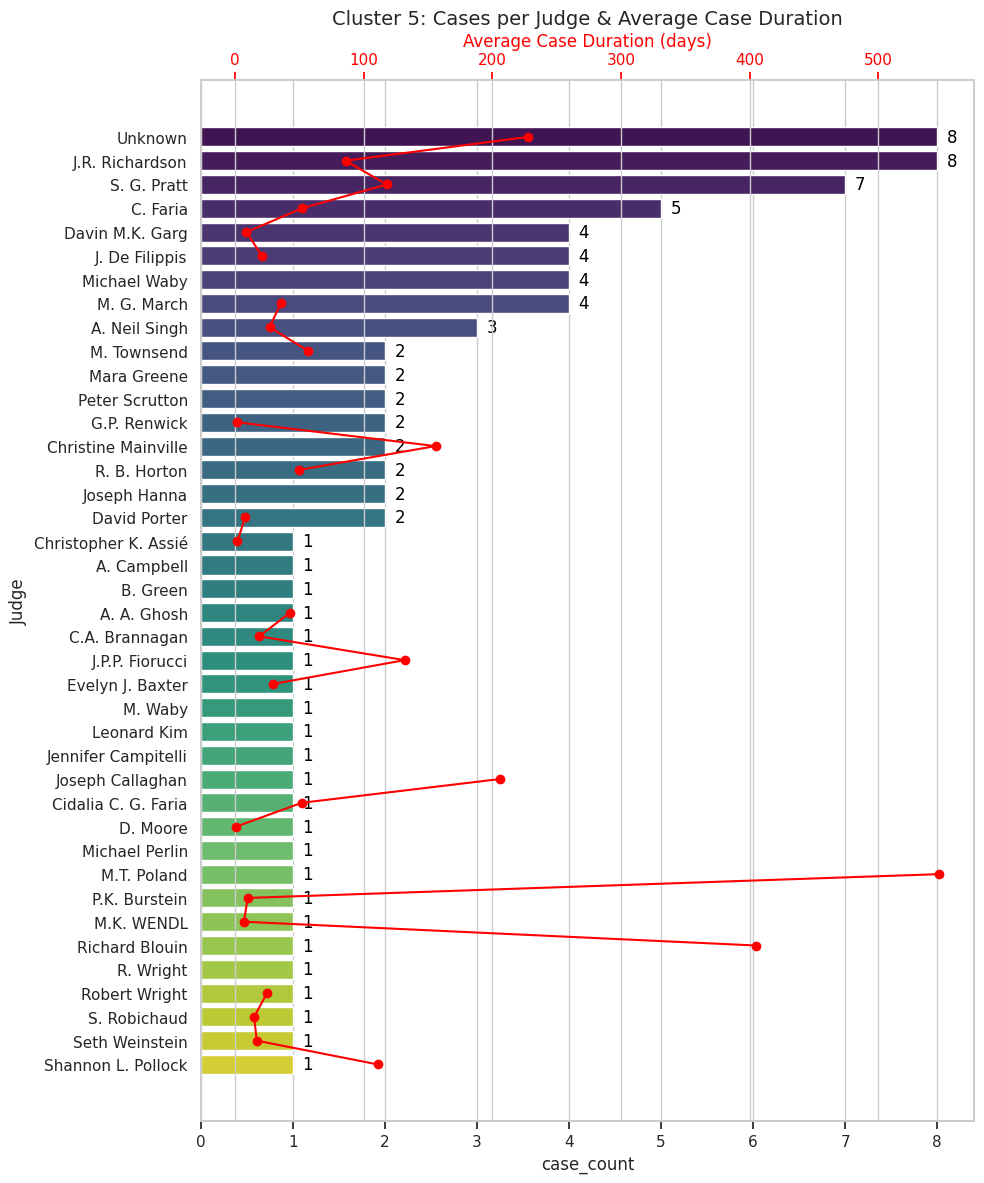

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import re

# -----------------------------
# 1️⃣ Function: Extract first Heard_Date
# -----------------------------
def extract_first_heard_date(value):
    """
    Extract the first date from a Heard_Date string.
    Returns pd.NaT if invalid or 'Unknown'.
    """
    if pd.isna(value) or str(value).strip().lower() == "unknown":
        return pd.NaT

    value = str(value)

    # Match multiple date formats
    date_pattern = r'\b\d{1,2}\s+[A-Za-z]+\s+\d{4}|' \
                   r'\b[A-Za-z]+\s+\d{1,2},\s*\d{4}|' \
                   r'\b\d{1,2}-[A-Za-z]{3}-\d{2,4}'

    matches = re.findall(date_pattern, value)
    if matches:
        try:
            return parser.parse(matches[0], fuzzy=True)
        except:
            return pd.NaT
    return pd.NaT

# -----------------------------
# 2️⃣ Process date columns
# -----------------------------
df["Heard_Date_dt"] = df["Heard_Date"].apply(extract_first_heard_date)

# Ensure Released_Date is datetime
if "Released_Date_dt" not in df.columns:
    df["Released_Date_dt"] = pd.to_datetime(df["Released_Date"], errors="coerce")

# Calculate case duration in days
df["case_duration_days"] = (df["Released_Date_dt"] - df["Heard_Date_dt"]).dt.days

# -----------------------------
# 3️⃣ Remove rows with NaN Cluster
# -----------------------------
df = df[df["Cluster"].notna()]

# -----------------------------
# 4️⃣ Calculate judge statistics per cluster
# -----------------------------
judge_stats_df = (
    df.groupby(["Cluster", "Judge"], as_index=False)
      .agg(
          case_count=("Case_Title", "count"),
          avg_case_duration_days=("case_duration_days", "mean")
      )
)

# -----------------------------
# 5️⃣ Loop through each cluster for stats and visualization
# -----------------------------
for cluster_id in sorted(df["Cluster"].unique()):
    print(f"\n=== Cluster {cluster_id} Statistics ===")

    cluster_judges = judge_stats_df[judge_stats_df["Cluster"] == cluster_id]
    total_judge_count = len(cluster_judges)

    # Overall average case duration for all judges in this cluster
    avg_duration = cluster_judges["avg_case_duration_days"].mean()

    print(f"Number of Judges: {total_judge_count}")
    print(f"Average Case Duration: {avg_duration:.2f} days")

    # -----------------------------
    # Visualization: Cases per Judge & Average Duration
    # -----------------------------
    judge_stats_sorted = cluster_judges.sort_values(by="case_count", ascending=False)
    if len(judge_stats_sorted) == 0:
        continue

    num_judges = len(judge_stats_sorted)
    plt.figure(figsize=(10, max(6, num_judges * 0.3)))
    sns.set(style="whitegrid")

    # Bar plot: number of cases
    ax = sns.barplot(
        x="case_count",
        y="Judge",
        data=judge_stats_sorted,
        palette="viridis"
    )

    # Add case count labels
    for index, row in enumerate(judge_stats_sorted.itertuples()):
        ax.text(
            row.case_count + 0.1,
            index,
            int(row.case_count),
            color='black',
            va="center"
        )

    # Secondary axis: average case duration
    ax2 = ax.twiny()
    ax2.plot(
        judge_stats_sorted["avg_case_duration_days"],
        range(len(judge_stats_sorted)),
        color="red",
        marker="o",
        linestyle="-",
        label="Avg Case Duration (days)"
    )
    ax2.set_xlabel("Average Case Duration (days)", color="red")
    ax2.tick_params(axis='x', colors='red')

    plt.title(f"Cluster {cluster_id}: Cases per Judge & Average Case Duration", fontsize=14)
    plt.tight_layout()